# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

Постройте модель со значением метрики качества *F1* не меньше 0.75. 

**Инструкция по выполнению проекта**

1. Загрузите и подготовьте данные.
2. Обучите разные модели. 
3. Сделайте выводы.

Для выполнения проекта применять *BERT* необязательно, но вы можете попробовать.

**Описание данных**

Данные находятся в файле `toxic_comments.csv`. Столбец *text* в нём содержит текст комментария, а *toxic* — целевой признак.

## Подготовка

### Импорт библиотек

Импортируем библиотеки, которые будут использоваться в проекте:

In [7]:
import nltk
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Dmitrii\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Dmitrii\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\Dmitrii\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping corpora\omw-1.4.zip.


True

In [2]:
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords as stopwords_nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
import lightgbm as lgb
pd.set_option('display.max_colwidth', -1)

C:\Users\Dmitrii\AppData\Local\Temp\ipykernel_4732\1542924373.py:12: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


### Загрузка и изучение данных

Загружаем данные из исходной таблицы, смотрим общую информацию.

In [3]:
comments = pd.read_csv('datasets/toxic_comments.csv')

display(comments.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


None

Пропущенных значений нет, преобразование типов данных не требуется.
<br><br>

Рассмотрим примеры нескольких строк.

In [4]:
display(comments.head(10))

,text,toxic
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0
3,"""\nMore\nI can't make any real suggestions on improvement - I wondered if the section statistics should be later on, or a subsection of """"types of accidents"""" -I think the references may need tidying so that they are all in the exact same format ie date format etc. I can do that later on, if no-one else does first - if you have any preferences for formatting style on references or want to do it yourself please let me know.\n\nThere appears to be a backlog on articles for review so I guess there may be a delay until a reviewer turns up. It's listed in the relevant form eg Wikipedia:Good_article_nominations#Transport """,0
4,"You, sir, are my hero. Any chance you remember what page that's on?",0
5,"""\n\nCongratulations from me as well, use the tools well. · talk """,0
6,COCKSUCKER BEFORE YOU PISS AROUND ON MY WORK,1
7,"Your vandalism to the Matt Shirvington article has been reverted. Please don't do it again, or you will be banned.",0
8,"Sorry if the word 'nonsense' was offensive to you. Anyway, I'm not intending to write anything in the article(wow they would jump on me for vandalism), I'm merely requesting that it be more encyclopedic so one can use it for school as a reference. I have been to the selective breeding page but it's almost a stub. It points to 'animal breeding' which is a short messy article that gives you no info. There must be someone around with expertise in eugenics? 93.161.107.169",0
9,alignment on this subject and which are contrary to those of DuLithgow,0


Негативные (токсичные) комментарии обозначены как *1* в столбце *toxic*.
<br><br>

Посмотрим на соотношение позитивных/нейтральных комментариев и негативных.

<AxesSubplot:>

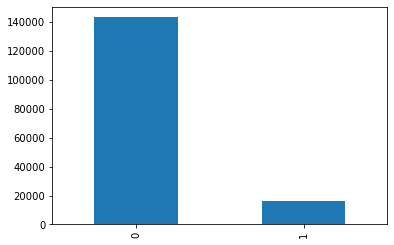

In [5]:
comments['toxic'].value_counts().plot(kind='bar')

Соотношение между классами примерно 90% к 10%, необходимо будет учесть данный дисбаланс при обучении моделей. 

### Обработка текстов

Проведём обработку текстов, необходимую для того чтобы на них можно было провести обучение моделей.

In [8]:
# удаляем лишние символы и переводим всё в нижний регистр
comments['w_o_punct'] = comments['text'].apply(lambda x: re.sub(r'[^a-zA-Z ]', ' ', x).lower())

# удаляем стоп-слова 
stop_words = set(stopwords_nltk.words('english')) 
comments['w_o_stopwords'] = comments['w_o_punct'].apply(lambda x: [w for w in x.split() if not w in stop_words])

# лемматизация и перевод в unicode
lemmatizer = nltk.WordNetLemmatizer()
comments['lemmas'] = comments['w_o_stopwords'].apply(lambda x: [lemmatizer.lemmatize(word) for word in x])
comments['lemmas'] = comments['lemmas'].astype('U')

Проверим результат проведённых операций:

In [9]:
comments.head(3)

,text,toxic,w_o_punct,w_o_stopwords,lemmas
0,"Explanation\nWhy the edits made under my username Hardcore Metallica Fan were reverted? They weren't vandalisms, just closure on some GAs after I voted at New York Dolls FAC. And please don't remove the template from the talk page since I'm retired now.89.205.38.27",0,explanation why the edits made under my username hardcore metallica fan were reverted they weren t vandalisms just closure on some gas after i voted at new york dolls fac and please don t remove the template from the talk page since i m retired now,"[explanation, edits, made, username, hardcore, metallica, fan, reverted, vandalisms, closure, gas, voted, new, york, dolls, fac, please, remove, template, talk, page, since, retired]","['explanation', 'edits', 'made', 'username', 'hardcore', 'metallica', 'fan', 'reverted', 'vandalism', 'closure', 'gas', 'voted', 'new', 'york', 'doll', 'fac', 'please', 'remove', 'template', 'talk', 'page', 'since', 'retired']"
1,"D'aww! He matches this background colour I'm seemingly stuck with. Thanks. (talk) 21:51, January 11, 2016 (UTC)",0,d aww he matches this background colour i m seemingly stuck with thanks talk january utc,"[aww, matches, background, colour, seemingly, stuck, thanks, talk, january, utc]","['aww', 'match', 'background', 'colour', 'seemingly', 'stuck', 'thanks', 'talk', 'january', 'utc']"
2,"Hey man, I'm really not trying to edit war. It's just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page. He seems to care more about the formatting than the actual info.",0,hey man i m really not trying to edit war it s just that this guy is constantly removing relevant information and talking to me through edits instead of my talk page he seems to care more about the formatting than the actual info,"[hey, man, really, trying, edit, war, guy, constantly, removing, relevant, information, talking, edits, instead, talk, page, seems, care, formatting, actual, info]","['hey', 'man', 'really', 'trying', 'edit', 'war', 'guy', 'constantly', 'removing', 'relevant', 'information', 'talking', 'edits', 'instead', 'talk', 'page', 'seems', 'care', 'formatting', 'actual', 'info']"


По результатам обработки текстов получаем в каждой строке набор лемм, на базе которых уже можно будет сформировать признаки для обучения моделей.

### Подготовка выборок для обучения

Целевым признаком для обучения моделей будет являться токсичность комментариев из столбца *toxic*.

Признаки для обучения будут сформированы как частота встречающихся слов, определенная с помощью TF-IDF ниже по столбцу *lemmas*.

In [10]:
target = comments['toxic']
features = comments['lemmas']

Разделяем данные на обучающую, валидационную и тестовую выборки:

In [11]:
features_train, features_valid, target_train, target_valid = train_test_split(
    features, target, train_size=0.8, test_size=0.2, random_state=12345, stratify=target)

features_valid, features_test, target_valid, target_test = train_test_split(
    features_valid, target_valid, train_size=0.5, test_size=0.5, random_state=12345, stratify=target_valid)

<br><br>
Определяем частоту слов с помощью TF-IDF.

Обучение для определения частоты слов проводим только на признаках из обучающей выборки, а преобразуем все выборки.

In [12]:
# на базе обучающей выборки определяем список слов, встречающихся во всех её текстах
count_tf_idf = TfidfVectorizer(stop_words=stop_words)
tf_idf = count_tf_idf.fit(features_train)

# преобразуем признак с набором лемм в набор признаков-слов с частотой их использования в каждой строке для обеих выборок
features_train = tf_idf.transform(features_train)
features_valid = tf_idf.transform(features_valid)
features_test = tf_idf.transform(features_test)

<br><br>
Убеждаемся в корректном разделении данных на выборки.

In [13]:
print('Размер таблицы с признаками в обучающей выборке', features_train.shape)
print('Размер таблицы с целевым признаком в обучающей выборке', target_train.shape)
print('Размер таблицы с признаками в валидационной выборке', features_valid.shape)
print('Размер таблицы с целевым признаком в валидационной выборке', target_valid.shape)
print('Размер таблицы с признаками в тестовой выборке', features_test.shape)
print('Размер таблицы с целевым признаком в тестовой выборке', target_test.shape)

Размер таблицы с признаками в обучающей выборке (127656, 138543)
Размер таблицы с целевым признаком в обучающей выборке (127656,)
Размер таблицы с признаками в валидационной выборке (15957, 138543)
Размер таблицы с целевым признаком в валидационной выборке (15957,)
Размер таблицы с признаками в тестовой выборке (15958, 138543)
Размер таблицы с целевым признаком в тестовой выборке (15958,)


Данные подготовлены к поиску наилучшей модели.

Определена частота, с которой каждое из более чем 100 тыс. слов появляется в каждом тексте.

## Обучение

### LogisticRegression

Проведём обучение модели Логистической регрессии на обучающей выборке, предскажем негативность комментариев для тестовой выборки и вычислим метрику F1.

In [14]:
%%time
f1_lr=[]

for solver in ['newton-cg', 'sag', 'saga', 'lbfgs', 'liblinear']:
    model = LogisticRegression(random_state=12345, class_weight='balanced', penalty='l2', solver=solver) 
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    f1 = f1_score(target_valid, predictions)
    f1_lr.append({'Algorithm': 'LogisticRegression', 
                  'Hyperparameters': {'class_weight':'balanced', 'penalty':'l2', 'solver': solver}, 
                  'F1 score': f1})
        
pd.DataFrame(f1_lr).sort_values('F1 score', ascending=False)

c:\Users\Dmitrii\anaconda3\lib\site-packages\sklearn\linear_model\_sag.py:352: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
c:\Users\Dmitrii\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:814: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


CPU times: total: 1min 18s
Wall time: 34.2 s


,Algorithm,Hyperparameters,F1 score
1,LogisticRegression,"{'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'sag'}",0.762555
0,LogisticRegression,"{'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'newton-cg'}",0.762347
3,LogisticRegression,"{'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'lbfgs'}",0.762139
4,LogisticRegression,"{'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'liblinear'}",0.762139
2,LogisticRegression,"{'class_weight': 'balanced', 'penalty': 'l2', 'solver': 'saga'}",0.761101


С помощью добавления гиперпараметров, в частности *penalty='l2'*, удалось достигнуть требуемый уровень качества, при котором значение метрики F1 выше 0.75.

###  RandomForestClassifier

Проведём обучение модели с помощью алгоритма классификации Случайный лес на обучающей выборке, предскажем негативность комментариев для тестовой выборки и вычислим метрику F1.

In [15]:
%%time
f1_rfc = []

for est in range(20, 41, 10):
    for depth in range(50, 71, 10):            
        model = RandomForestClassifier(random_state=12345, class_weight = 'balanced', 
                                       n_estimators=est, max_depth=depth)        
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        f1 = f1_score(target_valid, predictions)
        f1_rfc.append({'Algorithm': 'RandomForestClassifier', 
                       'Hyperparameters': {'n_estimators': est, 'max_depth': depth}, 
                       'F1 score': f1})
        
pd.DataFrame(f1_rfc).sort_values('F1 score', ascending=False)

CPU times: total: 3min 26s
Wall time: 3min 27s


,Algorithm,Hyperparameters,F1 score
8,RandomForestClassifier,"{'n_estimators': 40, 'max_depth': 70}",0.510127
2,RandomForestClassifier,"{'n_estimators': 20, 'max_depth': 70}",0.509322
5,RandomForestClassifier,"{'n_estimators': 30, 'max_depth': 70}",0.506667
7,RandomForestClassifier,"{'n_estimators': 40, 'max_depth': 60}",0.493935
4,RandomForestClassifier,"{'n_estimators': 30, 'max_depth': 60}",0.489126
1,RandomForestClassifier,"{'n_estimators': 20, 'max_depth': 60}",0.474091
3,RandomForestClassifier,"{'n_estimators': 30, 'max_depth': 50}",0.467523
0,RandomForestClassifier,"{'n_estimators': 20, 'max_depth': 50}",0.463908
6,RandomForestClassifier,"{'n_estimators': 40, 'max_depth': 50}",0.463618


Результат работы Случайного леса существенно ниже требуемых значений по метрике F1, хуже Логистической регрессии.

### LGBMClassifier

Проведём обучение модели с помощью алгоритма классификации на базе градиентного бустинга LightGBM на обучающей выборке, предскажем негативность комментариев для тестовой выборки и вычислим метрику F1.

In [16]:
%%time
f1_lgbm = []

for est in range(300, 501, 100):
    for depth in range (4, 6, 1):
        for lr in [0.25, 0.5]:
            model = lgb.LGBMClassifier(n_estimators=est, learning_rate=lr, max_depth=depth, random_state=12345)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            f1 = f1_score(target_valid, predictions)
            f1_lgbm.append({'Algorithm': 'LGBMClassifier',
                            'Hyperparameters': {'n_estimators': est, 'max_depth': depth, 'learning_rate': lr},
                            'F1 score': f1})

pd.DataFrame(f1_lgbm).sort_values('F1 score', ascending=False)

CPU times: total: 47min 36s
Wall time: 8min 10s


,Algorithm,Hyperparameters,F1 score
10,LGBMClassifier,"{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.25}",0.779376
11,LGBMClassifier,"{'n_estimators': 500, 'max_depth': 5, 'learning_rate': 0.5}",0.779089
3,LGBMClassifier,"{'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.5}",0.777589
7,LGBMClassifier,"{'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.5}",0.776876
8,LGBMClassifier,"{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.25}",0.772375
6,LGBMClassifier,"{'n_estimators': 400, 'max_depth': 5, 'learning_rate': 0.25}",0.771843
2,LGBMClassifier,"{'n_estimators': 300, 'max_depth': 5, 'learning_rate': 0.25}",0.771642
9,LGBMClassifier,"{'n_estimators': 500, 'max_depth': 4, 'learning_rate': 0.5}",0.771352
5,LGBMClassifier,"{'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.5}",0.768814
4,LGBMClassifier,"{'n_estimators': 400, 'max_depth': 4, 'learning_rate': 0.25}",0.767094


Классификатор на базе градиентного бустинга LightGBM с высокими значениями гиперпараметров позволяет достичь требуемых значений метрики F1 в 0.75.

### Проверка на тестовой выборке

В рамках обучения и валидации наилучшие результаты по метрике F1 показала сделующая модель:
* Алгоритм: LGBMClassifier
* Гиперпараметры:
    * random_state=12345,
    * n_estimators=500,
    * max_depth=5,
    * learning_rate= 0.25

Проверим её эффективность на тестовой выборке:

In [17]:
model = lgb.LGBMClassifier(n_estimators=500, learning_rate=0.25, max_depth=5, random_state=12345) 
model.fit(features_train, target_train)
predictions = model.predict(features_test)
f1 = f1_score(target_test, predictions)
print('F1 Score наилучшей модели на тестовой выборке', f1)

F1 Score наилучшей модели на тестовой выборке 0.7510608203677511


## Выводы

В рамках проекта была определена наилучшая модель, которая позволяет определять негативность (токсичность) комментариев пользователей с требуемым уровнем качества. 

Значение метрики F1 данной модели на тестовой выборке составило ~0.7544, что выше требуемых целями проекта 0.75.

В основе данной модели - классификатор LGBMClassifier с гиперпараметрами: 
* random_state=12345, 
* n_estimators=500, 
* max_depth=5, 
* learning_rate= 0.25.

В ходе выполнения работ:
* Импортирован датасет с размеченными данными по негативности комментариев.
* Преобразован исходный текст комментариев:
    * удалены лишние символы
    * всё переведено в нижний регистр
    * удалены стоп-слова
    * проведена лемматизация
    * всё переведено в unicode
* Сформированы обучающая и тестовая выборки, признаками которых стали частоты, с которыми в каждом тексте встречаются слова (леммы) из всего датасета.
* Проведено обучение моделей на основе 3 алгоритмов, один из которых обеспечил требуемый результат.